# Librerías

In [1]:
import re
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from concurrent.futures import ProcessPoolExecutor

from transformers import pipeline

from textblob import TextBlob
from wordcloud import WordCloud

from kneed import KneeLocator

import warnings
# Ignorar todas las advertencias (no recomendado en general)
warnings.filterwarnings("ignore")

c:\Users\David Lopez\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Carga y limpieza del dataset

In [2]:
def clean_data(df_original):
    # Definir los nombres de las columnas
    column_names = ['sentiment_score', 'tweet_id', 'tweet_date', 'query', 'user', 'tweet_text']

    # Asignar los nombres de las columnas al DataFrame
    df_original.columns = column_names

    # Eliminar columnas innecesarias
    df = df_original.drop(columns=['tweet_id', 'query'])

    # Convertir la columna de fecha a formato datetime
    df['tweet_date'] = pd.to_datetime(df['tweet_date'])

    # Extraer la hora del día y agregarla como una nueva columna
    df['hour_of_day'] = df['tweet_date'].dt.hour
    df['day_of_week'] = df['tweet_date'].dt.dayofweek  # Lunes=0, Domingo=6
    
    # Extraeer solo la fecha en la columna tweet_date
    df['tweet_date'] = df['tweet_date'].dt.date

    # Aplicar la función de limpieza y tokenización al texto de los tweets
    df['clean_tweet'], df['mentioned_users'] = zip(*df['tweet_text'].apply(clean_text))
    
    #df['mentioned_users'] = df['mentioned_users'].fillna('')

    # Eliminar columnas originales de texto sin procesar
    df = df.drop(columns=['tweet_text'])
    
    # Eliminar filas donde 'clean_tweet' es una cadena vacía
    df = df[df['clean_tweet'].str.strip() != '']

    df= df.dropna()

    return df

# Crear instancias de objetos NLTK una sola vez fuera de la función para mejorar el rendimiento
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar enlaces o direcciones web
    text = re.sub(r'http\S+|www\S+', '', text)
    # Extraer los nombres de usuario mencionados con arroba y eliminarlos del texto
    users_mentioned = re.findall(r'@([A-Za-z0-9_]+)', text)
    text = re.sub(r'@\w+', '', text)
    # Eliminar números y caracteres especiales (excepto letras y espacios), y dobles espacios
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    # Tokenizar, eliminar stopwords y lematizar
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in word_tokenize(text) if word not in stop_words]
    # Unir los tokens en una sola cadena
    cleaned_text = ' '.join(cleaned_tokens)
    # Unir los nombres de usuario mencionados en una cadena separada por comas
    users_mentioned_str = ','.join(users_mentioned)
    return cleaned_text, users_mentioned_str

## Cargar datos originales

In [3]:
# Cargar datos

df_original = pd.read_csv("C:/Users/David Lopez/Desktop/Caso analitica 2 twitter/Caso 2 twitter sentimientos.csv")


## Limpiar datos

In [4]:
df=clean_data(df_original)
df.head(5)

,sentiment_score,tweet_date,user,hour_of_day,day_of_week,clean_tweet,mentioned_users
0,0,2009-04-06,scotthamilton,22,0,upset cant update facebook texting might cry r...,
1,0,2009-04-06,mattycus,22,0,dived many time ball managed save rest go bound,kenichan
2,0,2009-04-06,ElleCTF,22,0,whole body feel itchy like fire,
3,0,2009-04-06,Karoli,22,0,behaving im mad cant see,nationwideclass
4,0,2009-04-06,joy_wolf,22,0,whole crew,kwesidei


# Calcular Puntuación sentimental  (Polaridad)

In [5]:
#    Realiza un muestreo aleatorio de un DataFrame.
def random_sample(df, sample_size):
    random_indices = np.random.choice(df.index, size=sample_size, replace=False)
    return df.loc[random_indices]

# Definir una función para calcular la puntuación de sentimiento y ajustarla al rango (-5 a 5)
def calculate_sentiment(text):
    analysis = TextBlob(text)
    # Normalizar la polaridad al rango de -5 a 5
    polarity = analysis.sentiment.polarity * 5
    return polarity

# Instantiate the SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Definir una función para ajustar la puntuación de VADER al rango (-5 a 5)
def calculate_sentiment(text):
    # Obtener la puntuación de VADER para el texto
    vader_score = sid.polarity_scores(text)['compound']
    # Ajustar la puntuación al rango (-5 a 5)
    adjusted_score = vader_score * 5
    return adjusted_score

# Calcular la puntuación de sentimiento ajustada para cada tweet 
df['sentiment_score'] = df['clean_tweet'].apply(calculate_sentiment)

sample_size = 5000  # Tamaño de la muestra
sample_df = random_sample(df, sample_size)

# Tokenización y vectorización usando TF-IDF en la muestra
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(sample_df['clean_tweet'])

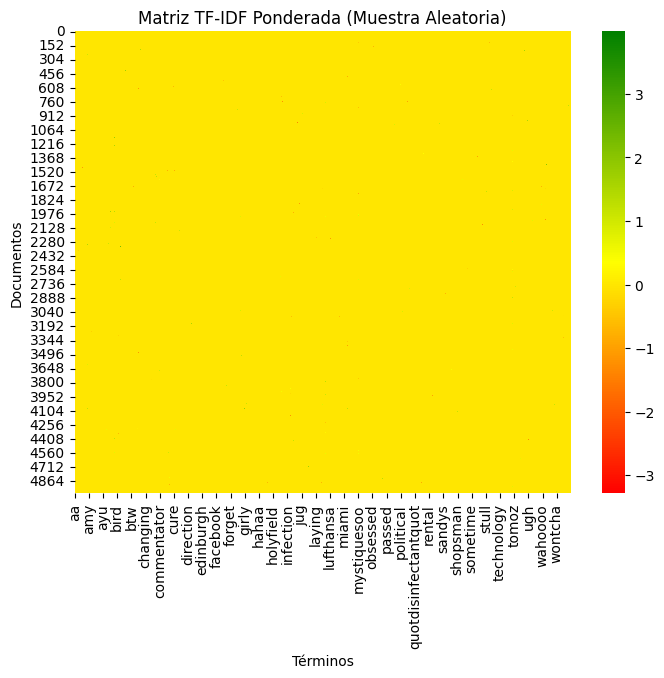

In [6]:

# Multiplicar cada fila de la matriz TF-IDF por la puntuación compuesta de VADER para cada tweet
weighted_tfidf_matrix = tfidf_matrix.multiply(np.array(sample_df['sentiment_score'])[:, np.newaxis])

# Convertir la matriz TF-IDF ponderada a un DataFrame para facilitar la visualización
weighted_tfidf_df = pd.DataFrame(weighted_tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Define una paleta de colores personalizada de rojo a verde
custom_cmap = mcolors.LinearSegmentedColormap.from_list("", ["red", "yellow", "green"])

# Visualiza la matriz TF-IDF ponderada como un mapa de calor con la paleta de colores personalizada
plt.figure(figsize=(8, 6))
sns.heatmap(weighted_tfidf_df, cmap=custom_cmap)
plt.title('Matriz TF-IDF Ponderada (Muestra Aleatoria)')
plt.xlabel('Términos')
plt.ylabel('Documentos')
plt.show()

## Guardar datos limpios

In [7]:

"""# Ruta relativa al directorio actual
file_path = '/Users/adrianacastillo/Documentos/La Salle/Casos Analitica/Práctica 2/twitter_polarity.csv'
# Guardar el DataFrame en un archivo CSV en la carpeta actual
df.to_csv(file_path, index=False)"""

"# Ruta relativa al directorio actual\nfile_path = '/Users/adrianacastillo/Documentos/La Salle/Casos Analitica/Práctica 2/twitter_polarity.csv'\n# Guardar el DataFrame en un archivo CSV en la carpeta actual\ndf.to_csv(file_path, index=False)"

In [8]:
df.head(5) 

,sentiment_score,tweet_date,user,hour_of_day,day_of_week,clean_tweet,mentioned_users
0,-3.6345,2009-04-06,scotthamilton,22,0,upset cant update facebook texting might cry r...,
1,2.4695,2009-04-06,mattycus,22,0,dived many time ball managed save rest go bound,kenichan
2,-1.2500,2009-04-06,ElleCTF,22,0,whole body feel itchy like fire,
3,-2.4695,2009-04-06,Karoli,22,0,behaving im mad cant see,nationwideclass
4,0.0000,2009-04-06,joy_wolf,22,0,whole crew,kwesidei


In [19]:
df

,sentiment_score,tweet_date,user,hour_of_day,day_of_week,clean_tweet,mentioned_users,Flesch_Score,Complejidad_Texto
0,-3.6345,2009-04-06,scotthamilton,22,0,upset cant update facebook texting might cry r...,,59.30,Moderadamente difícil
1,2.4695,2009-04-06,mattycus,22,0,dived many time ball managed save rest go bound,kenichan,100.00,Muy fácil
2,-1.2500,2009-04-06,ElleCTF,22,0,whole body feel itchy like fire,,100.00,Muy fácil
3,-2.4695,2009-04-06,Karoli,22,0,behaving im mad cant see,nationwideclass,83.32,Fácil
4,0.0000,2009-04-06,joy_wolf,22,0,whole crew,kwesidei,100.00,Muy fácil
...,...,...,...,...,...,...,...,...,...
1599994,3.4540,2009-06-16,AmandaMarie1028,8,1,woke school best feeling ever,,83.32,Fácil
1599995,1.5910,2009-06-16,TheWDBoards,8,1,thewdbcom cool hear old walt interview,,56.93,Moderadamente difícil
1599996,1.8060,2009-06-16,bpbabe,8,1,ready mojo makeover ask detail,,83.32,Fácil
1599997,2.8595,2009-06-16,tinydiamondz,8,1,happy th birthday boo alll time tupac amaru sh...,,79.26,Bastante fácil


# ANÁLISIS

# 1.	¿Cuál es la distribución de las polaridades y complejidad de lectura/escritura de los tweets en el dataset?

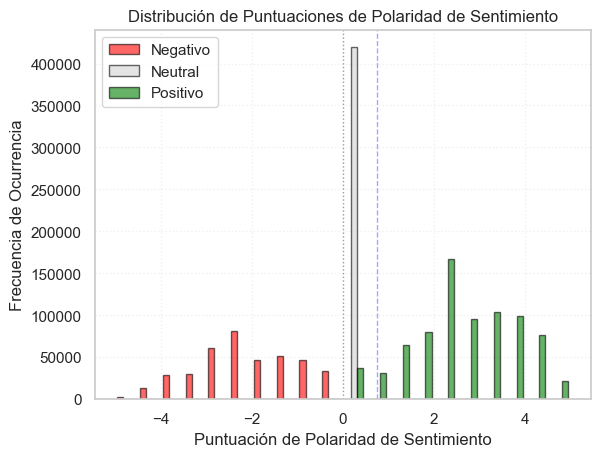

In [9]:
# Configurar el estilo de la gráfica
sns.set(style="whitegrid")

# Obtener los valores de la columna de puntuaciones de polaridad
sentiment_scores = df['sentiment_score']

# Definir los límites de los bins
bins = np.linspace(-5, 5, 21)  # 20 bins igualmente espaciados entre -5 y 5

# Dividir los datos en tres categorías: negativa, neutral y positiva
neg_scores = sentiment_scores[sentiment_scores < 0]
neu_scores = sentiment_scores[sentiment_scores == 0]
pos_scores = sentiment_scores[sentiment_scores > 0]

# Crear los histogramas para cada categoría con colores correspondientes
plt.hist([neg_scores, neu_scores, pos_scores], bins, color=['red', 'lightgray', 'green'], edgecolor='black', label=['Negativo', 'Neutral', 'Positivo'], alpha=0.6)

plt.xlabel('Puntuación de Polaridad de Sentimiento')
plt.ylabel('Frecuencia de Ocurrencia')
plt.title('Distribución de Puntuaciones de Polaridad de Sentimiento')

# Personalizar la leyenda
plt.legend(loc='upper left', frameon=True)

# Agregar líneas de referencia para la polaridad neutra y la media
plt.axvline(x=0, color='black', linestyle=':', linewidth=1, alpha=0.35)  # Hacer más opaca la línea de referencia para la polaridad neutra
plt.axvline(x=sentiment_scores.mean(), color='blue', linestyle='--', linewidth=1, alpha=0.35)  # Hacer más opaca la línea de referencia para la media


# Ajustar la transparencia de la cuadrícula
plt.grid(True, linestyle=':', alpha=0.3)

## a. ¿Hay una mayor cantidad de tweets positivos, negativos o neutrales?

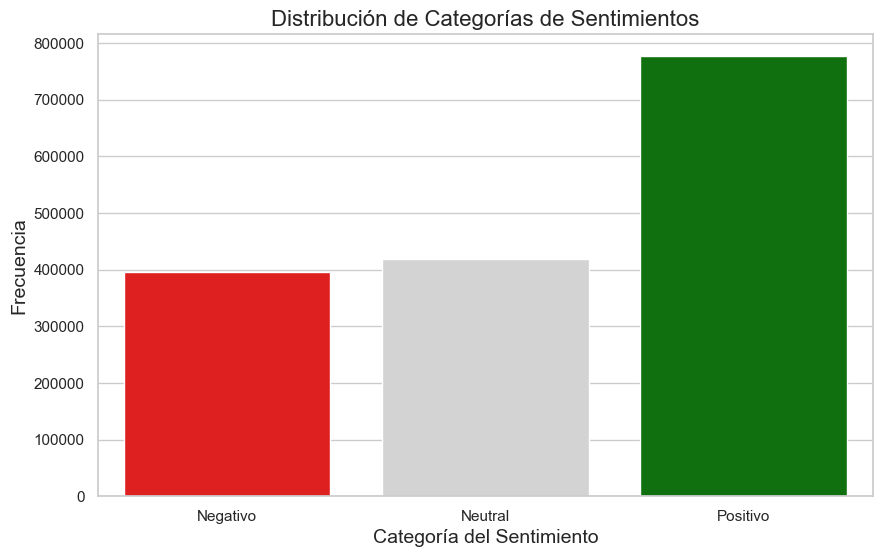

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Configurar el estilo de la gráfica
sns.set(style="whitegrid")

# Contar la frecuencia de cada categoría de sentimiento
neg_scores = df['sentiment_score'][df['sentiment_score'] < 0]
neu_scores = df['sentiment_score'][df['sentiment_score'] == 0]
pos_scores = df['sentiment_score'][df['sentiment_score'] > 0]

category_counts = pd.Series({
    'Negativo': len(neg_scores),
    'Neutral': len(neu_scores),
    'Positivo': len(pos_scores)
})

# Crear el gráfico de barras con colores específicos
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette=["red", "lightgray", "green"])

# Añadir título y etiquetas
ax.set_title("Distribución de Categorías de Sentimientos", fontsize=16)
ax.set_xlabel("Categoría del Sentimiento", fontsize=14)
ax.set_ylabel("Frecuencia", fontsize=14)

# Rotar las etiquetas del eje x si es necesario
plt.xticks(rotation=0)

# Mostrar el gráfico de barras
plt.show()



## b.	¿Cómo se relacionan las distintas polaridades según la complejidad de lectura/escritura de los tweets?


Text(0.5, 1.0, 'Relationship between Polarity and Average Word Length')

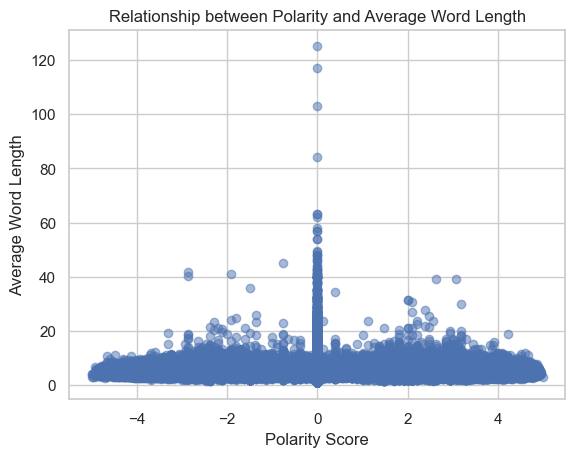

In [ ]:
# Se calcula la longitud promedio de las palabras y se visualiza cómo se relacionan con la polaridad.
df['average_word_length'] = df['clean_tweet'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()))

plt.scatter(df['sentiment_score'], df['average_word_length'], alpha=0.5)
plt.xlabel('Polarity Score')
plt.ylabel('Average Word Length')
plt.title('Relationship between Polarity and Average Word Length')

Para poder verificar la complejidad de un texto en ingles podemos utilizar una liberia que se llama textstat,
que proporciona un buen manejo de indices para el idioma ingles, utilzaremos la metrica flesch reading ease que nos permite obtener
los indices.

La escala del indice de puntuacion es la siguiente:

90-100: Muy fácil de leer. Entendido por un estudiante promedio de 11 años.
80-90: Fácil de leer. Conversacional en inglés para consumidores.
70-80: Bastante fácil de leer.
60-70: Texto estándar. Entendido por estudiantes de 13-15 años.
50-60: Moderadamente difícil de leer.
30-50: Difícil de leer.
10-30: Muy difícil de leer. Mejor entendido por graduados universitarios.
0-10: Extremadamente difícil de leer. Mejor entendido por graduados universitarios avanzados.

Ademas como ya hemos realizado una limpieza anterior algunos tweets han quedado algunos textos muy corto, la fórmula de Flesch puede producir resultados atípicos. Esto se debe a que la fórmula supone un cierto rango y tipo de contenido textual para funcionar correctamente.

Para ello se realiza un funcion ajustada que me permita obtener valores en la escala de 0 a 100

In [14]:
import textstat

def safe_flesch_reading_ease(text):
    score = textstat.flesch_reading_ease(text)
    return min(score, 100)  # Limita la puntuación a un máximo de 100

# Uso de la función ajustada
df['Flesch_Score'] = df['clean_tweet'].apply(safe_flesch_reading_ease)

In [15]:
import pandas as pd

def clasificar_complejidad(score):
    if score >= 90:
        return "Muy fácil"
    elif score >= 80:
        return "Fácil"
    elif score >= 70:
        return "Bastante fácil"
    elif score >= 60:
        return "Texto estándar"
    elif score >= 50:
        return "Moderadamente difícil"
    elif score >= 30:
        return "Difícil"
    elif score >= 10:
        return "Muy difícil"
    else:
        return "Extremadamente difícil"

"""def clasificar_complejidad(score):
    if score >= 70:
        return "Facil"
    elif score > 30:
        return  "Estandar"
    else:
        return "Dificil"""



# Suponiendo que 'Flesch_Score' es una columna en DF_twitter que contiene las puntuaciones de Flesch Reading Ease
df['Complejidad_Texto'] = df['Flesch_Score'].apply(clasificar_complejidad)

In [16]:
segmento_counts = df['Complejidad_Texto'].value_counts().sort_index()
print(segmento_counts)

Complejidad_Texto
Bastante fácil            227203
Difícil                   186625
Extremadamente difícil     47576
Fácil                     239739
Moderadamente difícil     147902
Muy difícil                28239
Muy fácil                 533500
Texto estándar            181501
Name: count, dtype: int64


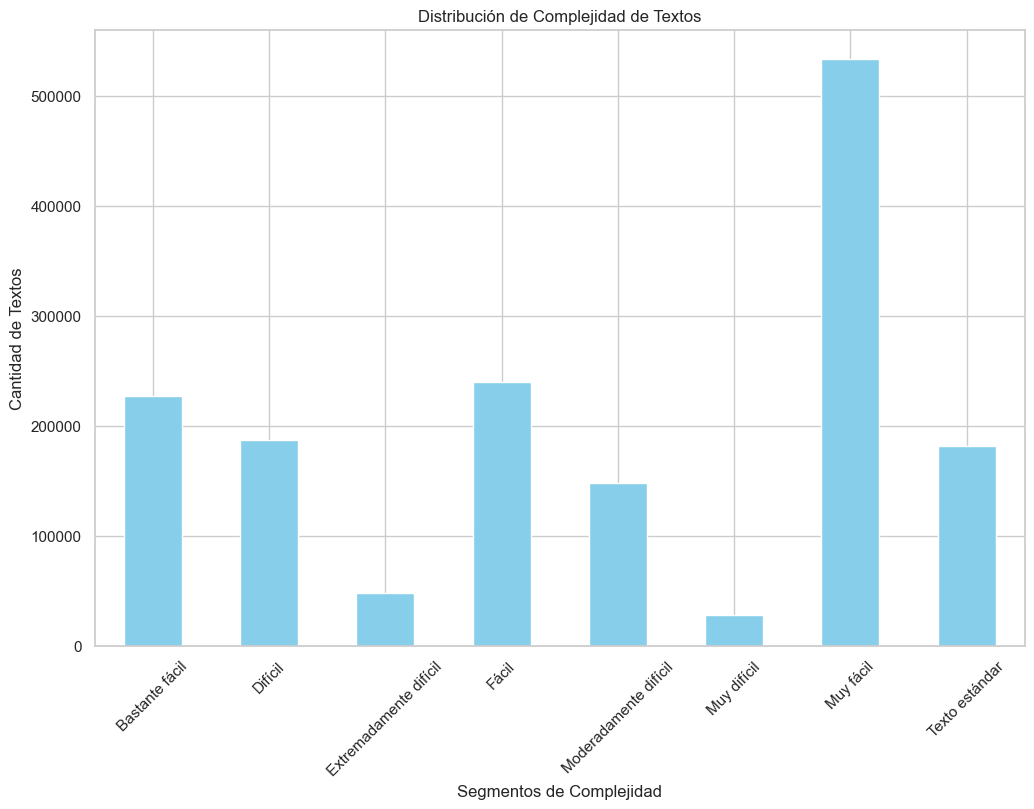

In [17]:
import matplotlib.pyplot as plt

# Crear un gráfico de barras de los conteos de segmentos
plt.figure(figsize=(12, 8))
segmento_counts.plot(kind='bar', color='skyblue')
plt.title('Distribución de Complejidad de Textos')
plt.xlabel('Segmentos de Complejidad')
plt.ylabel('Cantidad de Textos')
plt.xticks(rotation=45)
plt.show()

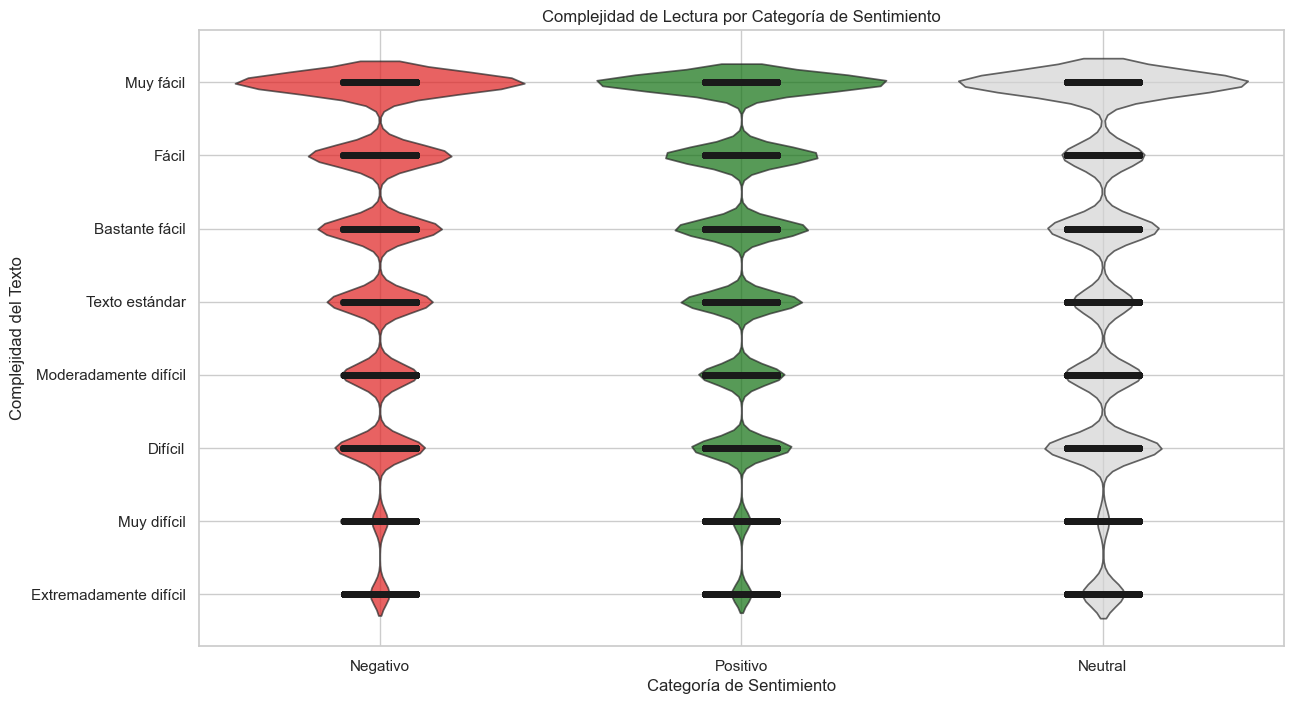

In [28]:



# Asegurarse de que 'Complejidad_Texto' es categórico y ordenado
df['Complejidad_Texto'] = pd.Categorical(df['Complejidad_Texto'], categories=[
    'Muy fácil', 'Fácil', 'Bastante fácil', 'Texto estándar', 
    'Moderadamente difícil', 'Difícil', 'Muy difícil', 'Extremadamente difícil'], ordered=True)

# Crear la columna 'Categoria_sentimiento' en el DataFrame
df['Categoria_sentimiento'] = df['sentiment_score'].apply(lambda x: 'Positivo' if x > 0 else ('Neutral' if x == 0 else 'Negativo'))

# Definir la paleta de colores para cada categoría
palette = {
    'Negativo': 'red',
    'Neutral': 'lightgray',
    'Positivo': 'green'
}

# Crear el gráfico de violín para visualizar la relación entre polaridad del sentimiento y complejidad de lectura
plt.figure(figsize=(14, 8))
sns.violinplot(x='Categoria_sentimiento', y='Complejidad_Texto', data=df, palette=palette, inner=None, alpha=0.7)

# Añadir stripplot para mostrar los puntos individuales
sns.stripplot(x='Categoria_sentimiento', y='Complejidad_Texto', data=df, color='k', alpha=0.6, jitter=True, dodge=True)

plt.title('Complejidad de Lectura por Categoría de Sentimiento')
plt.xlabel('Categoría de Sentimiento')
plt.ylabel('Complejidad del Texto')
plt.grid(True)  # Añadir una cuadrícula para mejorar la visualización
plt.show()

# 2.	¿Existen patrones gramaticales o sintácticos comunes en los tweets con polaridad positiva o negativa? Por ejemplo, puede que los tweets positivos tiendan a utilizar más palabras de agradecimiento o elogios, mientras que los tweets negativos utilizan más palabras de crítica o enojo.

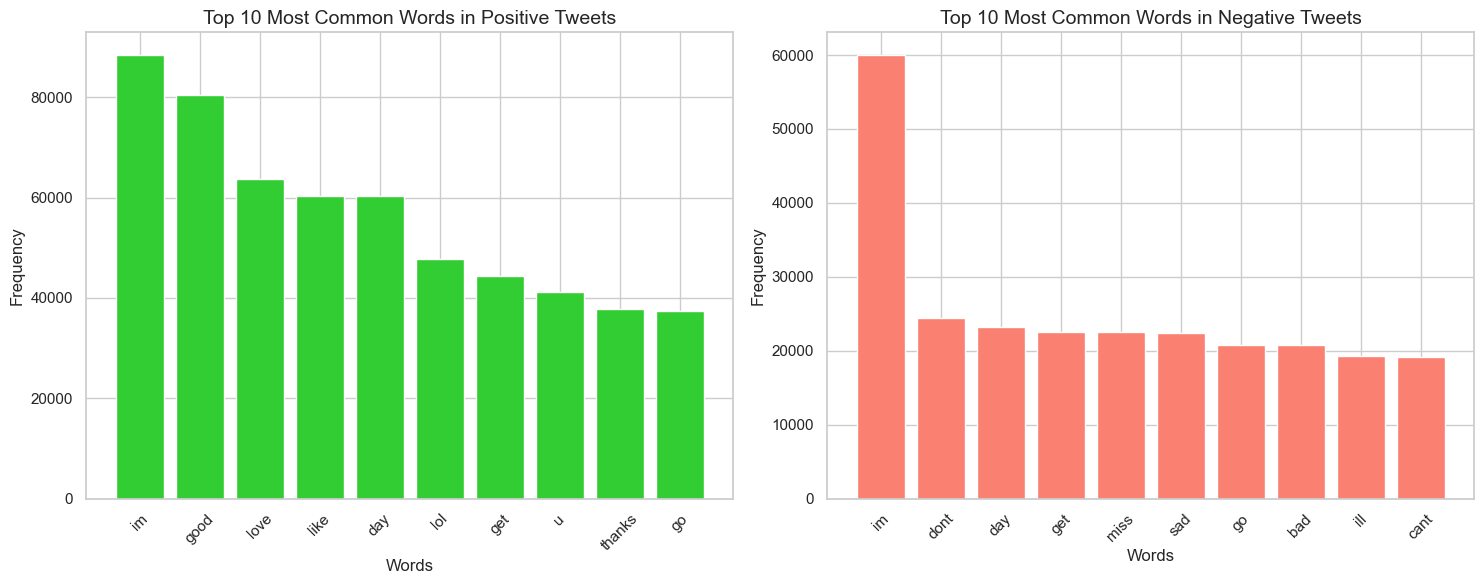

In [ ]:
# Dividir el dataframe en tweets positivos y negativos
positive_tweets = df[df['sentiment_score'] > 0]['clean_tweet']
negative_tweets = df[df['sentiment_score'] < 0]['clean_tweet']

# Contar las palabras más comunes en tweets positivos y negativos
positive_words = ' '.join(positive_tweets).split()
negative_words = ' '.join(negative_tweets).split()

positive_word_counts = Counter(positive_words)
negative_word_counts = Counter(negative_words)

# Configurar el tamaño de las gráficas
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Gráfica para palabras más comunes en tweets positivos
axes[0].bar(*zip(*positive_word_counts.most_common(10)), color='limegreen')
axes[0].set_title('Top 10 Most Common Words in Positive Tweets', fontsize=14)
axes[0].set_xlabel('Words', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Gráfica para palabras más comunes en tweets negativos
axes[1].bar(*zip(*negative_word_counts.most_common(10)), color='salmon')
axes[1].set_title('Top 10 Most Common Words in Negative Tweets', fontsize=14)
axes[1].set_xlabel('Words', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()

# 3.	¿Qué usuarios tienden a generar tweets con una polaridad más positiva o negativa? ¿Hay alguna relación entre la polaridad de los tweets y el número de seguidores de un usuario?

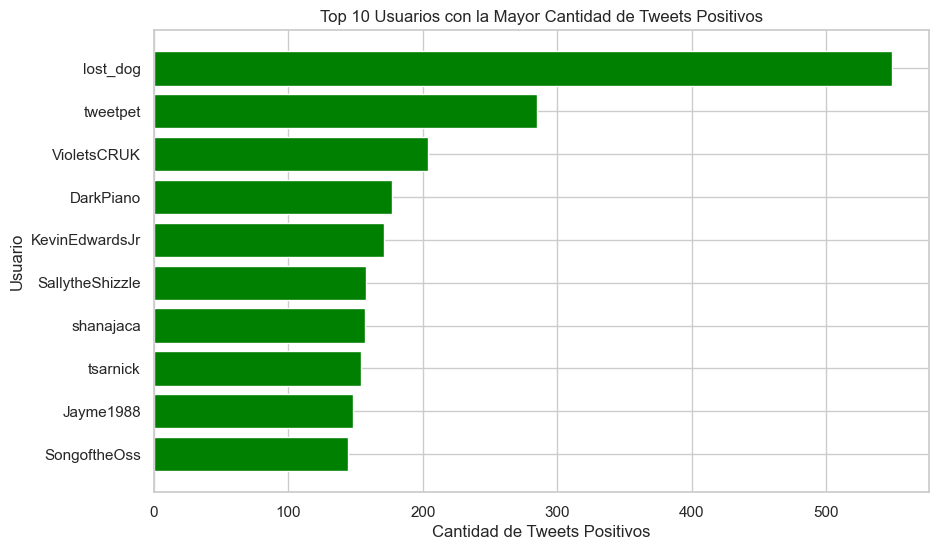

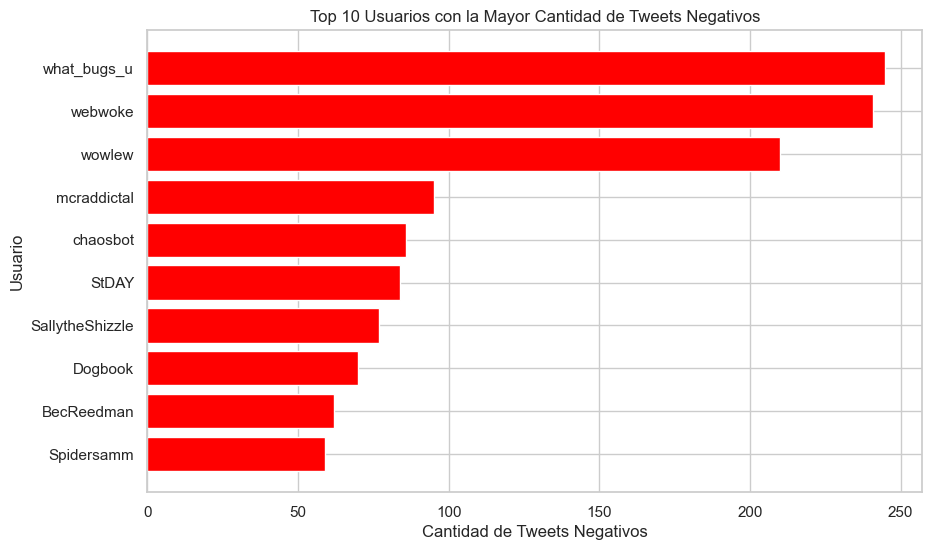

"\n\n# Calcular la polaridad neta promedio para los usuarios con estimaciones de seguidores\nuser_sentiment_counts['followers_estimate'] = user_sentiment_counts['user'].map(followers_estimate)\nuser_sentiment_counts.dropna(inplace=True)\n\n# Visualizar la relación entre la polaridad neta promedio y el número estimado de seguidores\nplt.figure(figsize=(10, 6))\nplt.scatter(user_sentiment_counts['followers_estimate'], user_sentiment_counts['net_sentiment'], alpha=0.5)\nplt.xlabel('Número Estimado de Seguidores')\nplt.ylabel('Polaridad Neta Promedio')\nplt.title('Relación entre Seguidores y Polaridad Neta de Tweets')\nplt.show()\n\n"

In [ ]:
# Filtrar los tweets con polaridad positiva y negativa
positive_tweets = df[df['sentiment_score'] > 0]
negative_tweets = df[df['sentiment_score'] < 0]

# Contar la cantidad de tweets positivos y negativos por usuario
positive_tweets_count = positive_tweets.groupby('user').size().reset_index(name='positive_tweets_count')
negative_tweets_count = negative_tweets.groupby('user').size().reset_index(name='negative_tweets_count')

# Fusionar los recuentos de tweets positivos y negativos por usuario
user_sentiment_counts = pd.merge(positive_tweets_count, negative_tweets_count, on='user', how='outer').fillna(0)

# Calcular la polaridad neta (positiva - negativa) por usuario
user_sentiment_counts['net_sentiment'] = user_sentiment_counts['positive_tweets_count'] - user_sentiment_counts['negative_tweets_count']

# Identificar los usuarios con la mayor cantidad de tweets positivos y negativos
top_positive_users = user_sentiment_counts.sort_values(by='positive_tweets_count', ascending=False).head(10)
top_negative_users = user_sentiment_counts.sort_values(by='negative_tweets_count', ascending=False).head(10)

# Visualizar los usuarios con la mayor cantidad de tweets positivos
plt.figure(figsize=(10, 6))
plt.barh(top_positive_users['user'], top_positive_users['positive_tweets_count'], color='green')
plt.xlabel('Cantidad de Tweets Positivos')
plt.ylabel('Usuario')
plt.title('Top 10 Usuarios con la Mayor Cantidad de Tweets Positivos')
plt.gca().invert_yaxis()  # Invertir el eje y para que el usuario con más tweets esté en la parte superior
plt.show()

# Visualizar los usuarios con la mayor cantidad de tweets negativos
plt.figure(figsize=(10, 6))
plt.barh(top_negative_users['user'], top_negative_users['negative_tweets_count'], color='red')
plt.xlabel('Cantidad de Tweets Negativos')
plt.ylabel('Usuario')
plt.title('Top 10 Usuarios con la Mayor Cantidad de Tweets Negativos')
plt.gca().invert_yaxis()  # Invertir el eje y para que el usuario con más tweets esté en la parte superior
plt.show()

# Ahora estimemos el número de seguidores utilizando las menciones en los tweets
all_mentions = df['mentioned_users'].str.split().explode().dropna()
followers_estimate = all_mentions.value_counts()

'''

# Calcular la polaridad neta promedio para los usuarios con estimaciones de seguidores
user_sentiment_counts['followers_estimate'] = user_sentiment_counts['user'].map(followers_estimate)
user_sentiment_counts.dropna(inplace=True)

# Visualizar la relación entre la polaridad neta promedio y el número estimado de seguidores
plt.figure(figsize=(10, 6))
plt.scatter(user_sentiment_counts['followers_estimate'], user_sentiment_counts['net_sentiment'], alpha=0.5)
plt.xlabel('Número Estimado de Seguidores')
plt.ylabel('Polaridad Neta Promedio')
plt.title('Relación entre Seguidores y Polaridad Neta de Tweets')
plt.show()

'''


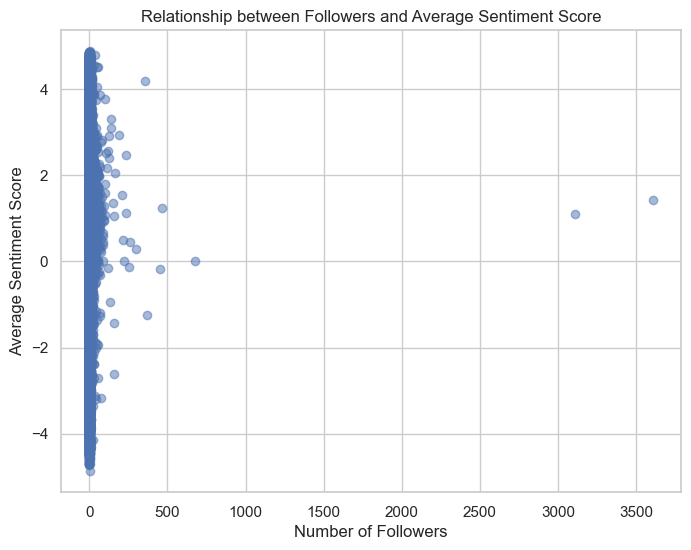

In [ ]:
# Estimar el número de seguidores de cada usuario basándose en las menciones en los tweets
all_mentions = df['mentioned_users'].str.split().explode().dropna()
followers_counter = Counter(all_mentions)
followers_df = pd.DataFrame(list(followers_counter.items()), columns=['user', 'followers'])

# Calcular la polaridad promedio de los tweets de cada usuario y la cantidad de tweets positivos y negativos
user_sentiment = df.groupby('user')['sentiment_score'].agg(['mean', 'count']).reset_index()
user_sentiment.columns = ['user', 'avg_sentiment', 'tweet_count']

# Fusionar los DataFrames para tener la información de seguidores, polaridad y cantidad de tweets
merged_df = pd.merge(user_sentiment, followers_df, on='user', how='left')

'''
# Identificar usuarios con la polaridad promedio más positiva y más negativa
top_positive_users = merged_df.sort_values(by='avg_sentiment', ascending=False).head(10)
top_negative_users = merged_df.sort_values(by='avg_sentiment').head(10)

# Visualizar los usuarios con la polaridad promedio más positiva y más negativa
plt.figure(figsize=(10, 5))
plt.barh(top_positive_users['user'], top_positive_users['avg_sentiment'], color='green')
plt.xlabel('Average Sentiment Score')
plt.ylabel('User')
plt.title('Top 10 Users with Highest Average Positive Sentiment')
plt.show()

plt.figure(figsize=(10, 5))
plt.barh(top_negative_users['user'], top_negative_users['avg_sentiment'], color='red')
plt.xlabel('Average Sentiment Score')
plt.ylabel('User')
plt.title('Top 10 Users with Lowest Average Negative Sentiment')
plt.show()

'''


# Relación entre la polaridad de los tweets y el número de seguidores de un usuario
plt.figure(figsize=(8, 6))
plt.scatter(merged_df['followers'], merged_df['avg_sentiment'], alpha=0.5)
plt.xlabel('Number of Followers')
plt.ylabel('Average Sentiment Score')
plt.title('Relationship between Followers and Average Sentiment Score')
plt.show()


# 4.	¿Hay alguna palabra o conjunto de palabras específicas que estén asociadas con tweets de polaridad extrema?

In [ ]:
# Filtrar tweets con polaridades extremas
threshold = 3  
# Identificar tweets de polaridad extrema
extreme_positive = df[df['sentiment_score'] > threshold]
extreme_negative = df[df['sentiment_score'] < -threshold]

# Vectorizar los tweets extremadamente positivos y negativos
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X_positive = vectorizer.fit_transform(extreme_positive['clean_tweet'])
X_negative = vectorizer.transform(extreme_negative['clean_tweet'])  # Usar transform en lugar de fit_transform

# Obtener las palabras más comunes en tweets extremadamente positivos y negativos
positive_words = vectorizer.get_feature_names_out()
negative_words = vectorizer.get_feature_names_out()

positive_word_counts = X_positive.sum(axis=0).A1
negative_word_counts = X_negative.sum(axis=0).A1

# Crear DataFrames para palabras y sus frecuencias
positive_freq_df = pd.DataFrame({'word': positive_words, 'count': positive_word_counts})
negative_freq_df = pd.DataFrame({'word': negative_words, 'count': negative_word_counts})

# Ordenar por frecuencia
positive_freq_df = positive_freq_df.sort_values(by='count', ascending=False).head(20)
negative_freq_df = negative_freq_df.sort_values(by='count', ascending=False).head(20)

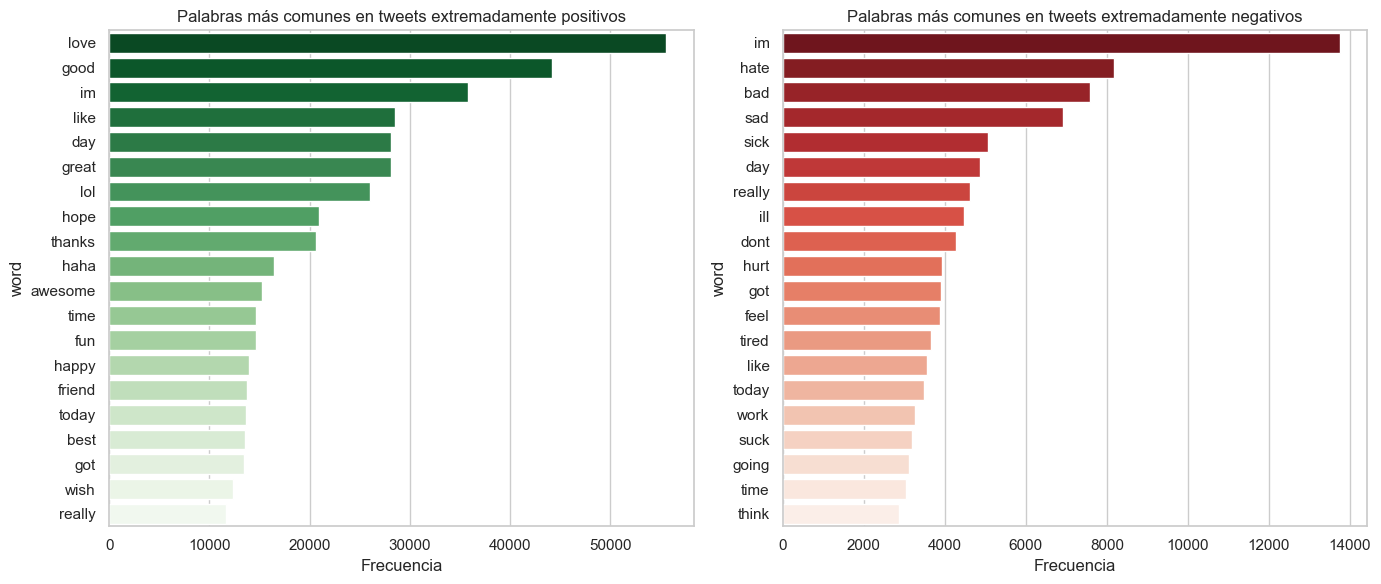

In [ ]:
# Visualización de palabras más comunes en polaridades extremas
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='count', y='word', data=positive_freq_df, palette='Greens_r')
plt.title('Palabras más comunes en tweets extremadamente positivos')
plt.xlabel('Frecuencia')

plt.subplot(1, 2, 2)
sns.barplot(x='count', y='word', data=negative_freq_df, palette='Reds_r')
plt.title('Palabras más comunes en tweets extremadamente negativos')
plt.xlabel('Frecuencia')

plt.tight_layout()
plt.show()

## a.	¿Estas palabras son más comunes en tweets sobre un tema en particular o están distribuidas en todo el dataset?

In [ ]:
# Comprobamos la distribución de palabras comunes en todo el dataset
df['clean_tweet'] = df['clean_tweet'].astype(str)
X_all = vectorizer.fit_transform(df['clean_tweet'])

all_words = vectorizer.get_feature_names_out()
all_word_counts = X_all.sum(axis=0).A1

# Crear DataFrame para palabras y sus frecuencias en todo el dataset
all_freq_df = pd.DataFrame({'word': all_words, 'count': all_word_counts})
all_freq_df = all_freq_df.sort_values(by='count', ascending=False).head(20)

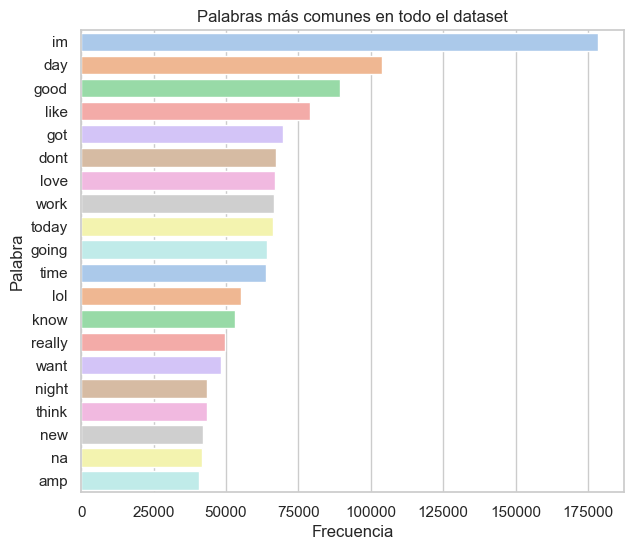

In [ ]:
# Visualización
plt.figure(figsize=(7, 6))
sns.barplot(x='count', y='word', data=all_freq_df, palette='pastel')
plt.title('Palabras más comunes en todo el dataset')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.show()

## b.	Escoge un tema y clusteriza los usuarios según polaridades.


In [ ]:
# Filtramos tweets relacionados con política
politics_keywords = ['politics', 'government', 'election', 'vote', 'policy']
df_politics = df[df['clean_tweet'].str.contains('|'.join(politics_keywords), case=False)]

# Vectorizamos los tweets relacionados con política
X_politics = vectorizer.fit_transform(df_politics['clean_tweet'])

# Reducimos la dimensionalidad
svd = TruncatedSVD(n_components=100)
X_politics_reduced = svd.fit_transform(X_politics)

# Aplicamos el método del codo para encontrar el número óptimo de clústeres
distortions = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_politics_reduced)
    distortions.append(kmeans.inertia_)


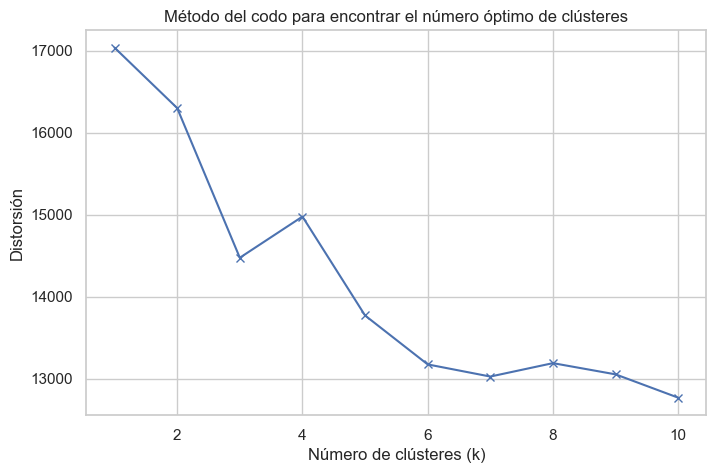

El número óptimo de clústeres es: 3


In [ ]:

# Visualización del método del codo
plt.figure(figsize=(8, 5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Distorsión')
plt.title('Método del codo para encontrar el número óptimo de clústeres')
plt.show()



# Encontrar el número óptimo de clústeres usando el método del codo
kl = KneeLocator(range(1, 11), distortions, curve='convex', direction='decreasing')
optimal_k = kl.elbow
print("El número óptimo de clústeres es:", optimal_k)


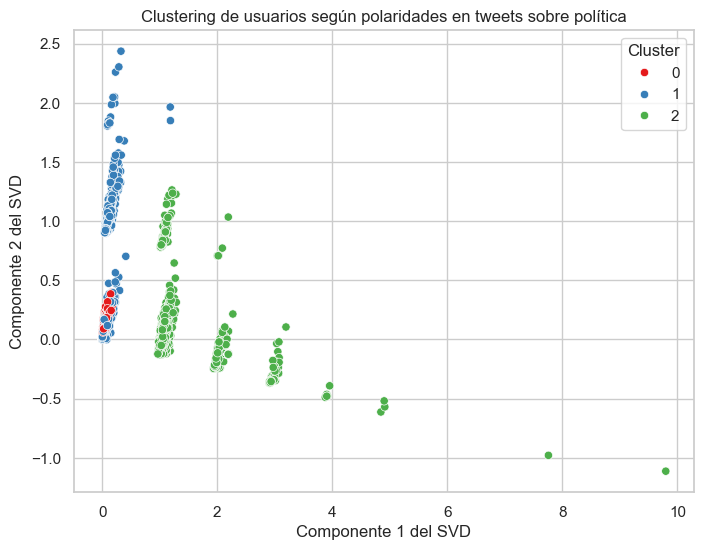

In [ ]:
# Clustering con el número óptimo de clústeres
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_politics['cluster'] = kmeans.fit_predict(X_politics_reduced)

# Visualización de clusters
plt.figure(figsize=(8, 6))  
sns.scatterplot(x=X_politics_reduced[:, 0], y=X_politics_reduced[:, 1], hue=df_politics['cluster'], palette='Set1')
plt.title('Clustering de usuarios según polaridades en tweets sobre política')
plt.xlabel('Componente 1 del SVD')  # Etiqueta del eje x modificada
plt.ylabel('Componente 2 del SVD')  # Etiqueta del eje y modificada
plt.legend(title='Cluster', loc='upper right')  # Ubicación de la leyenda especificada
plt.grid(True)  # Agregar cuadrícula para una mejor referencia visual
plt.show()


# 5.	¿Hay alguna correlación entre la polaridad de un tweet y la fecha en que se publicó?
## a.	¿Los tweets publicados durante ciertos períodos de tiempo tienden a ser más positivos o negativos que otros?

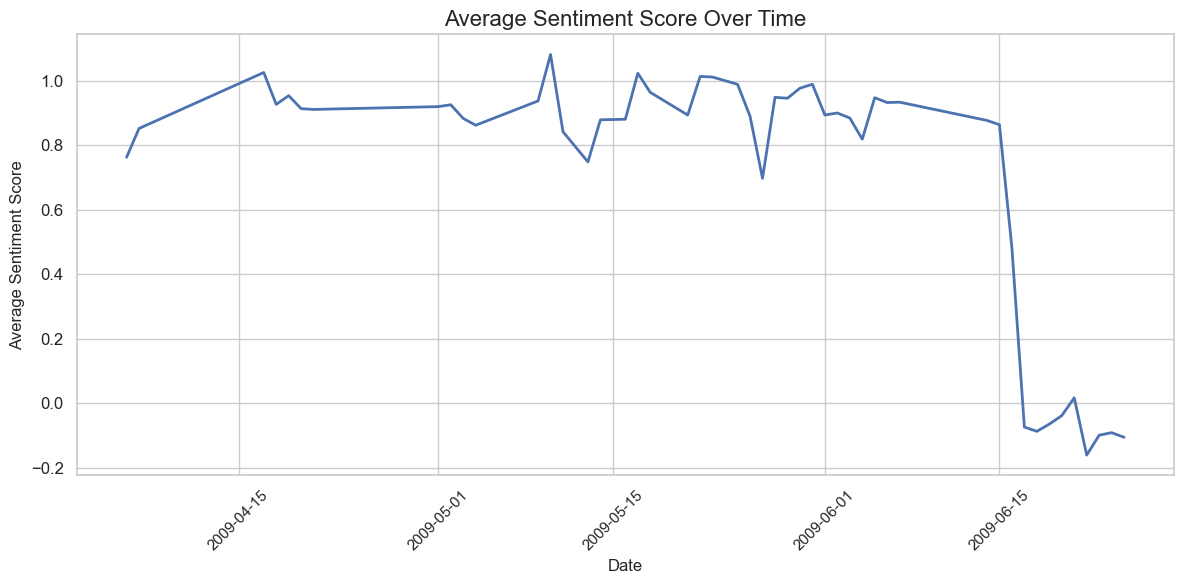

In [ ]:
# Convertir la columna 'tweet_date' a formato de fecha
df['tweet_date'] = pd.to_datetime(df['tweet_date'])

# Agrupar los tweets por fecha y calcular la polaridad promedio
daily_sentiment = df.groupby(df['tweet_date'].dt.date)['sentiment_score'].mean().reset_index()

# Configurar el estilo y contexto de seaborn
sns.set(style="whitegrid", context="notebook")

# Paleta de colores
colors = sns.color_palette("coolwarm", len(daily_sentiment))

# Visualizar la polaridad promedio de los tweets a lo largo del tiempo
plt.figure(figsize=(12, 6))
sns.lineplot(x='tweet_date', y='sentiment_score', data=daily_sentiment, linewidth=2, palette=colors)
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Score Over Time', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

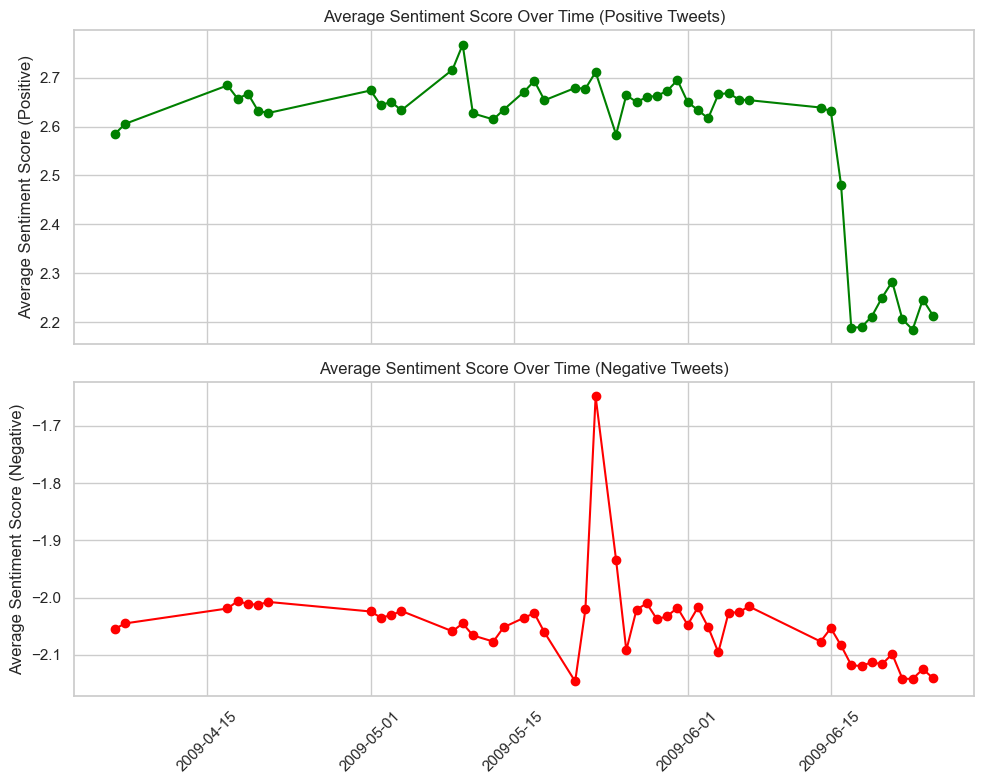

In [ ]:
# Filtrar tweets positivos y negativos
positive_tweets = df[df['sentiment_score'] > 0]
negative_tweets = df[df['sentiment_score'] < 0]

# Calcular la polaridad promedio de los tweets para cada fecha
positive_date_sentiment = positive_tweets.groupby(positive_tweets['tweet_date'].dt.date)['sentiment_score'].mean()
negative_date_sentiment = negative_tweets.groupby(negative_tweets['tweet_date'].dt.date)['sentiment_score'].mean()

# Crear subplots para tweets positivos y negativos
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Graficar polaridad promedio de tweets positivos
axes[0].plot(positive_date_sentiment.index, positive_date_sentiment.values, marker='o', color='green')
axes[0].set_ylabel('Average Sentiment Score (Positive)')
axes[0].set_title('Average Sentiment Score Over Time (Positive Tweets)')

# Graficar polaridad promedio de tweets negativos
axes[1].plot(negative_date_sentiment.index, negative_date_sentiment.values, marker='o', color='red')
axes[1].set_ylabel('Average Sentiment Score (Negative)')
axes[1].set_title('Average Sentiment Score Over Time (Negative Tweets)')

# Rotar las etiquetas del eje x para una mejor visualización
plt.xticks(rotation=45)

# Mostrar los gráficos
plt.tight_layout()
plt.show()

# 6.	Identifica los Top 10 Trolls y Top 10 Influencers. Justifica las características de un usuario Troll e Influencer.

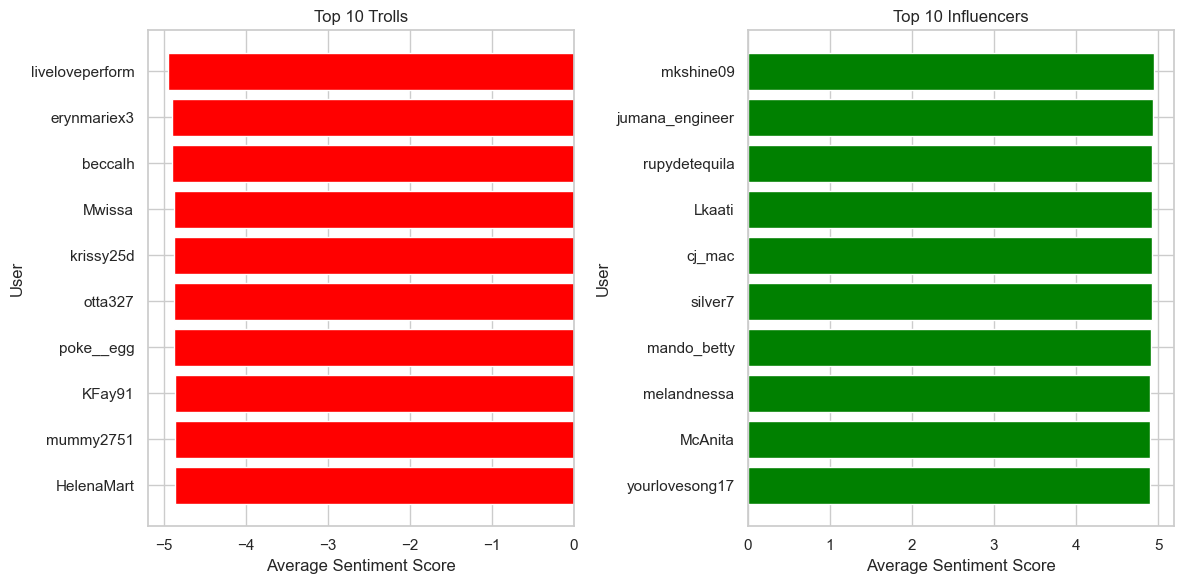

In [ ]:
# Analizar la polaridad promedio de los tweets por usuario
user_sentiment = df.groupby('user')['sentiment_score'].mean().reset_index()

# Identificar los Top 10 Trolls y Top 10 Influencers
top_trolls = user_sentiment.sort_values(by='sentiment_score').head(10)
top_influencers = user_sentiment.sort_values(by='sentiment_score', ascending=False).head(10)

# Visualización de los Top 10 Trolls y Top 10 Influencers
plt.figure(figsize=(12, 6))

# Top 10 Trolls
plt.subplot(1, 2, 1)
plt.barh(top_trolls['user'], top_trolls['sentiment_score'], color='red')
plt.xlabel('Average Sentiment Score')
plt.ylabel('User')
plt.title('Top 10 Trolls')
plt.gca().invert_yaxis()  # Invertir el eje y para que el usuario con la puntuación más baja esté en la parte superior

# Top 10 Influencers
plt.subplot(1, 2, 2)
plt.barh(top_influencers['user'], top_influencers['sentiment_score'], color='green')
plt.xlabel('Average Sentiment Score')
plt.ylabel('User')
plt.title('Top 10 Influencers')
plt.gca().invert_yaxis()  # Invertir el eje y para que el usuario con la puntuación más alta esté en la parte superior

plt.tight_layout()
plt.show()

Para identificar a los influencers y trolls, se calcula la polaridad promedio de los tweets de cada usuario y luego se seleccionan los usuarios con las puntuaciones más altas y más bajas, respectivamente. 

- **Influencers:** Los influencers son usuarios cuyos tweets tienden a tener una polaridad positiva alta en promedio. Esto puede indicar que sus publicaciones tienen un impacto positivo en su audiencia y que son percibidos como líderes de opinión o autoridades en ciertos temas.

- **Trolls:** Los trolls son usuarios cuyos tweets tienden a tener una polaridad negativa alta en promedio. Estos usuarios pueden estar involucrados en provocaciones, discusiones agresivas o comentarios ofensivos en línea, con el objetivo de generar controversia o molestia en la comunidad.

# Visualización

## 1.	¿Cómo se distribuyen los tweets según su polaridad a lo largo del tiempo?

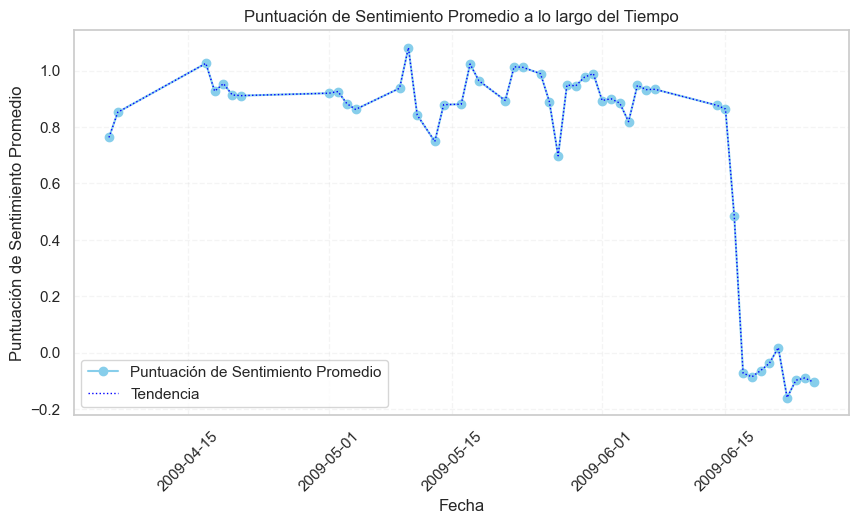

In [ ]:

# Analizar la polaridad promedio de los tweets por fecha
df['tweet_date'] = pd.to_datetime(df['tweet_date'])
# Extraer la hora del día y agregarla como una nueva columna
#df['hour_of_day'] = df['tweet_date'].dt.hour
#df['day_of_week'] = df['tweet_date'].dt.dayofweek  # Lunes=0, Domingo=6

#df['tweet_date'] = df['tweet_date'].dt.date

date_sentiment = df.groupby('tweet_date')['sentiment_score'].mean().reset_index()

# Visualizar la polaridad promedio de los tweets a lo largo del tiempo
plt.figure(figsize=(10, 5))
plt.grid(True, linestyle='--', alpha=0.2)
plt.plot(date_sentiment['tweet_date'], date_sentiment['sentiment_score'], marker='o', color='skyblue', label='Puntuación de Sentimiento Promedio')
plt.plot(date_sentiment['tweet_date'], date_sentiment['sentiment_score'], marker='', color='blue', linewidth=1, linestyle=':', label='Tendencia')
plt.xlabel('Fecha')
plt.ylabel('Puntuación de Sentimiento Promedio')

plt.title('Puntuación de Sentimiento Promedio a lo largo del Tiempo')
plt.xticks(rotation=45)
plt.legend()

## 2.	Visualiza el análisis sintáctico (número de palabras, frase, verbos, nombres…) de los top 10 Trolls e Influencers.

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/adrianacastillo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/adrianacastillo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


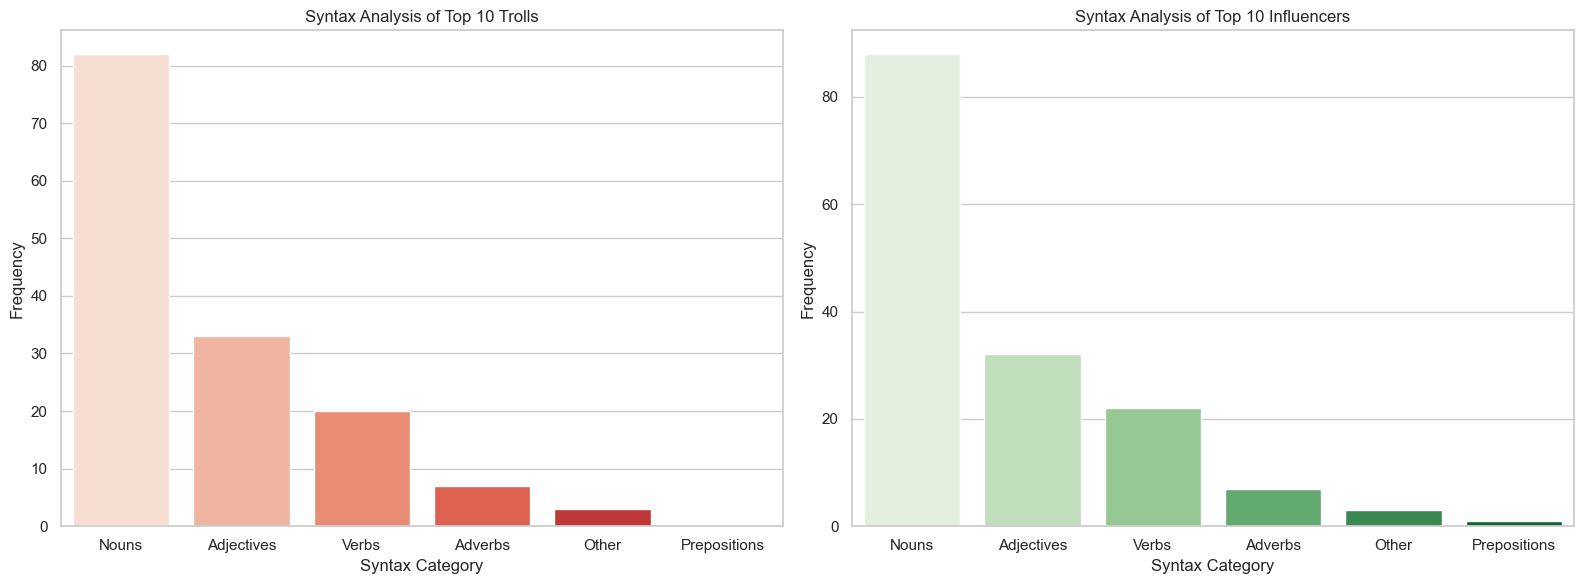

In [ ]:
# Puedes visualizar el análisis sintáctico de los tweets de los Top 10 Trolls e Influencers utilizando gráficos de barras o diagramas de pastel para mostrar la distribución de diferentes partes del discurso, como sustantivos, verbos, etc.
# Aquí hay un ejemplo para visualizar la distribución de partes del discurso en los tweets de los Top 10 Trolls:
top_troll_tweets = df[df['user'].isin(top_trolls['user'])]['clean_tweet']
top_influencer_tweets = df[df['user'].isin(top_influencers['user'])]['clean_tweet']


nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Configurar el estilo de Seaborn
sns.set(style="whitegrid")

# Función para analizar sintácticamente los tweets
def analyze_syntax(texts):
    syntax_results = {'Nouns': 0, 'Verbs': 0, 'Adjectives': 0, 'Adverbs': 0, 'Other': 0}
    
    # Definir categorías adicionales de partes del discurso
    extra_categories = {'Prepositions': 0}
    
    for text in texts:
        tokens = word_tokenize(text)
        tagged_tokens = pos_tag(tokens)
        
        for token, tag in tagged_tokens:
            if tag.startswith('NN'):  # Sustantivos
                syntax_results['Nouns'] += 1
            elif tag.startswith('VB'):  # Verbos
                syntax_results['Verbs'] += 1
            elif tag.startswith('JJ'):  # Adjetivos
                syntax_results['Adjectives'] += 1
            elif tag.startswith('RB'):  # Adverbios
                syntax_results['Adverbs'] += 1
            elif tag in ['IN']:  # Preposiciones
                extra_categories['Prepositions'] += 1
            else:
                syntax_results['Other'] += 1
    
    # Combinar los resultados de las partes del discurso básicas y adicionales
    syntax_results.update(extra_categories)
    
    return syntax_results

# Analizar sintácticamente los tweets de los Top 10 Trolls e Influencers
troll_syntax = analyze_syntax(top_troll_tweets)
influencer_syntax = analyze_syntax(top_influencer_tweets)

# Ordenar los resultados de mayor a menor valor
sorted_troll_syntax = dict(sorted(troll_syntax.items(), key=lambda item: item[1], reverse=True))
sorted_influencer_syntax = dict(sorted(influencer_syntax.items(), key=lambda item: item[1], reverse=True))

# Crear gráficos con Seaborn
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=list(sorted_troll_syntax.keys()), y=list(sorted_troll_syntax.values()), palette='Reds')
plt.title('Syntax Analysis of Top 10 Trolls')
plt.xlabel('Syntax Category')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.barplot(x=list(sorted_influencer_syntax.keys()), y=list(sorted_influencer_syntax.values()), palette='Greens')
plt.title('Syntax Analysis of Top 10 Influencers')
plt.xlabel('Syntax Category')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


# 3.	¿Existe alguna correlación entre el número de seguidores de un usuario y la polaridad de sus tweets? Representa visualmente esta relación.

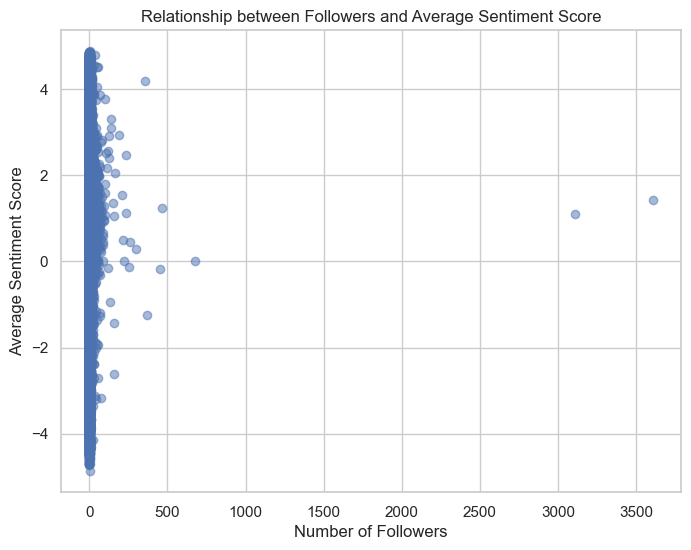

In [ ]:
# Relación entre la polaridad de los tweets y el número de seguidores de un usuario
plt.figure(figsize=(8, 6))
plt.scatter(merged_df['followers'], merged_df['avg_sentiment'], alpha=0.5)
plt.xlabel('Number of Followers')
plt.ylabel('Average Sentiment Score')
plt.title('Relationship between Followers and Average Sentiment Score')
plt.show()

# 4.	Crea una nube de palabras para cada polaridad.

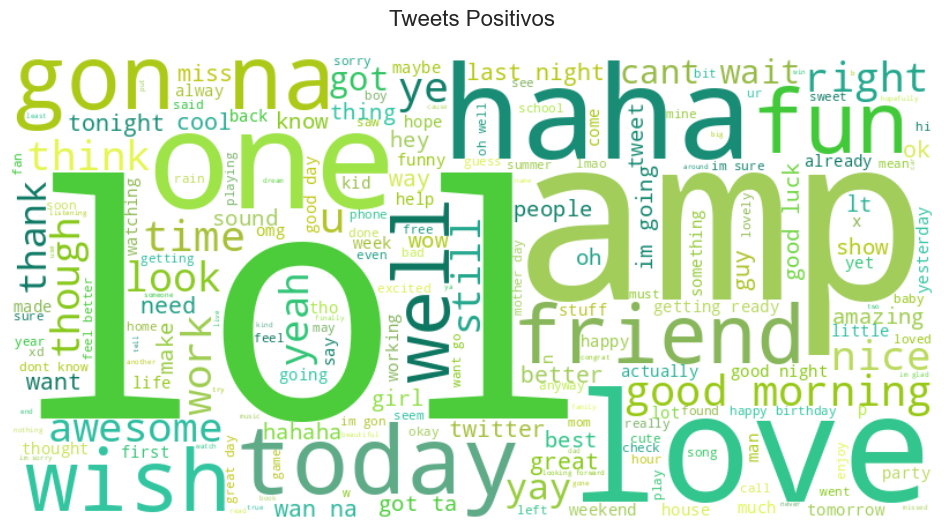

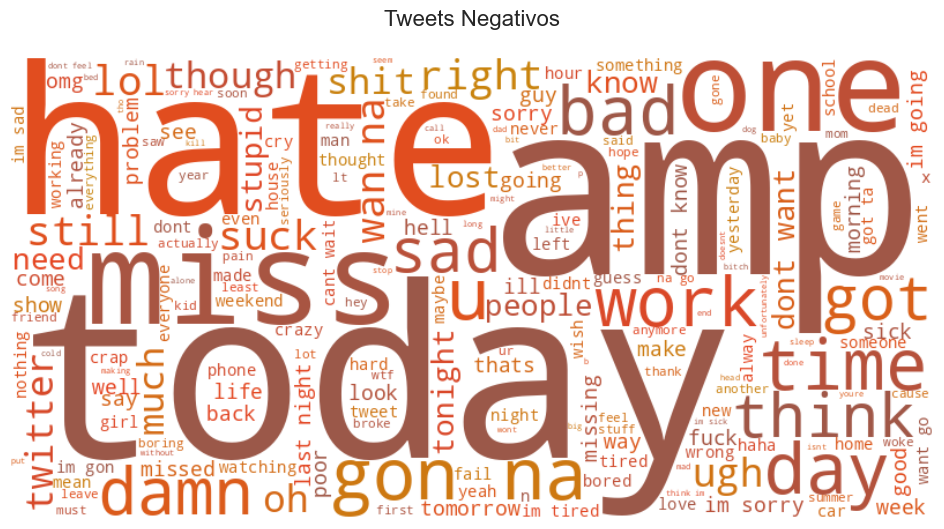

In [ ]:
# Función para generar la nube de palabras
def generate_wordcloud(text, title, colormap):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=colormap).generate(text)
    plt.figure(figsize=(12, 6))  # Aumenta el tamaño de la figura
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)  # Agrega un título y ajusta el tamaño de la fuente
    plt.axis('off')
    plt.show()

# Definir colores más positivos
positive_color = ['#53A695','#C4C917', '#86C917', '#A7CE65','#ECF855','#32C536','#32C5A8','#0E7762']  
# Definir colores más negativos
negative_color = ['#C8840D','#E54522','#9B5849']  

# Definir mapas de colores personalizados
positive_cmap = LinearSegmentedColormap.from_list("Positive", positive_color)
negative_cmap = LinearSegmentedColormap.from_list("Negative", negative_color)

# Generar nube de palabras para tweets positivos
positive_tweets = df[df['sentiment_score'] > 0]['clean_tweet']
generate_wordcloud(' '.join(positive_tweets), "Tweets Positivos\n", positive_cmap)

# Generar nube de palabras para tweets negativos
negative_tweets = df[df['sentiment_score'] < 0]['clean_tweet']
generate_wordcloud(' '.join(negative_tweets), "Tweets Negativos\n", negative_cmap)

# 5.	¿Cómo se distribuyen los tweets según su polaridad en función de la hora del día o el día de la semana?

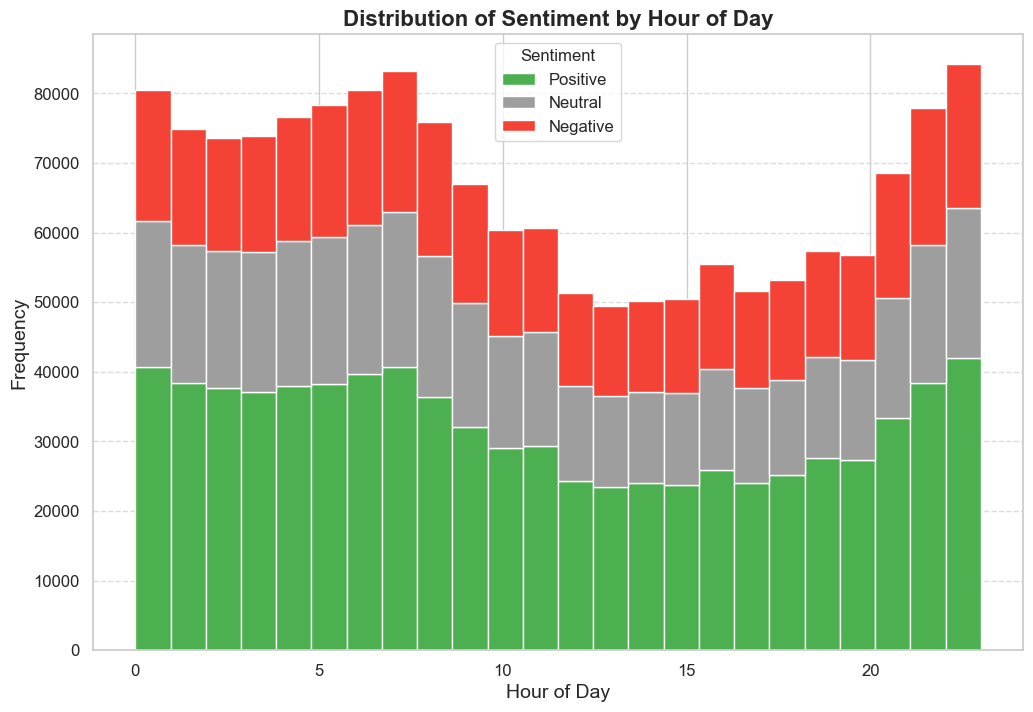

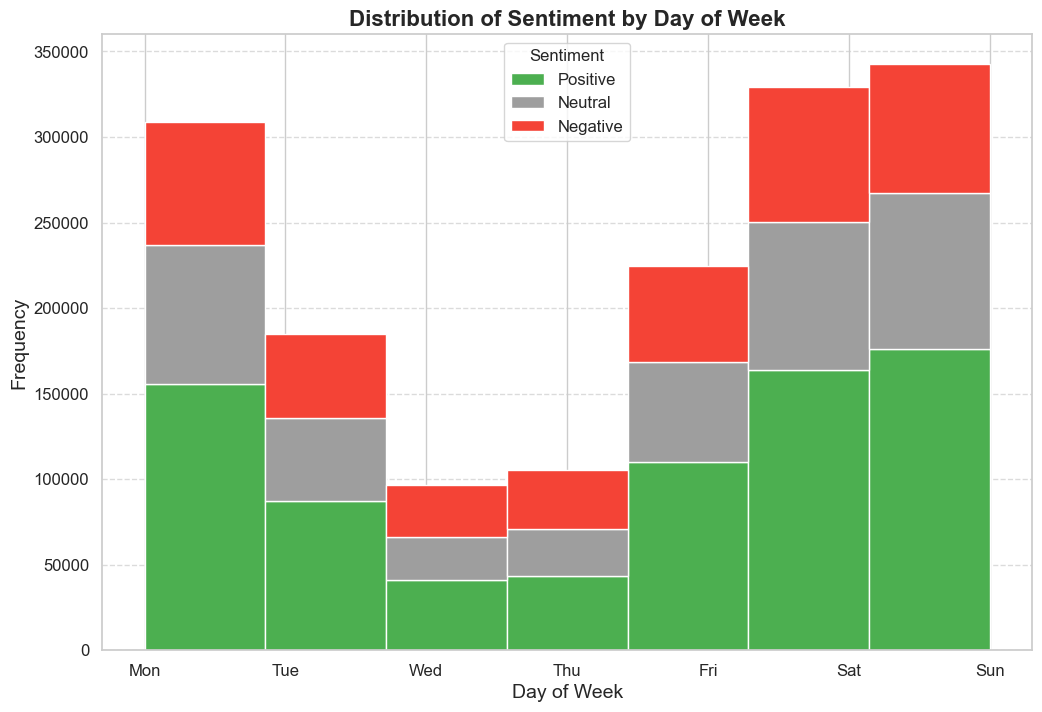

In [ ]:
# Configuración de estilo de Seaborn
sns.set(style="whitegrid")

# Visualizar la distribución de la polaridad de los tweets por hora del día
plt.figure(figsize=(12, 8))
plt.hist([df[df['sentiment_score'] > 0]['hour_of_day'], 
          df[df['sentiment_score'] == 0]['hour_of_day'], 
          df[df['sentiment_score'] < 0]['hour_of_day']], 
         bins=24, stacked=True, color=['#4CAF50', '#9E9E9E', '#F44336'], label=['Positive', 'Neutral', 'Negative'])
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Sentiment by Hour of Day', fontsize=16, fontweight='bold')
plt.legend(title='Sentiment', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualizar la distribución de la polaridad de los tweets por día de la semana
plt.figure(figsize=(12, 8))
plt.hist([df[df['sentiment_score'] > 0]['day_of_week'], 
          df[df['sentiment_score'] == 0]['day_of_week'], 
          df[df['sentiment_score'] < 0]['day_of_week']], 
         bins=7, stacked=True, color=['#4CAF50', '#9E9E9E', '#F44336'], label=['Positive', 'Neutral', 'Negative'])
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Sentiment by Day of Week', fontsize=16, fontweight='bold')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Sentiment', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
